# Flow Chart Creator 

I saw [this image](images/foul_mood_guide.jpg) and it inspired me to create a flow chart for what to do when you're in a foul mood. So I took a screenshot, submitted it ChatGPT and asked it to create the flow chart. It did pretty well with a few tweaks, but I noticed a lot of repetetion, and defining each node and edge sequentially felt wrong. The the authoring of a flow chart graph did not represent the spirit of the image it was aiming to create. I was further disillusioned by the lack of interactive documentation in the otherwise wonderful [Python implimentation](https://graphviz.readthedocs.io/en/stable/index.html) of Graphviz. Using 'attrs' as keyword argument, forcing the user to lookup attribute names and types, leaves a lot to be desired, especially when working in Jupyter (see Jeremy Howard's thoughts on the matter referenced in my 'delegation' implimentation).

I want to create a generalized, reusable pattern to create flow charts using Graphviz using Pydantic to model, validate, and re-use keyword arguments. And I want the definition of the graph structure to more closely mirror the intended output.

In [ ]:
from graphviz import Digraph, Graph
from typing import * 

Let's start by looking at ChatGPT's solution to creating a flowchart from our source image. 

In [ ]:
def create_foul_mood_flowchart():
    # Initialize the flowchart
    flowchart = Digraph("Foul Mood Guide", format="svg")
    flowchart.attr(rankdir="TB")

    # Add nodes with positioning
    flowchart.node("Start", "Are you hydrated?", pos="0,0!")
    flowchart.node("HydrationYes", "Yes", pos="1,-1!", constraint="false")
    flowchart.node("HydrationNo", "No", pos="-1,-1!", constraint="false")
    flowchart.node("DrinkWater", "If not, have a glass of water.", pos="-2,-2!", constraint="false")

    flowchart.node("Eaten", "Have you eaten in the past 3 hours?", pos="2,-2!")
    flowchart.node("EatenYes", "Yes", pos="3,-3!", constraint="false")
    flowchart.node("EatenNo", "No", pos="1,-3!", constraint="false")
    flowchart.node("EatFood", "If not, get some food with protein, not just carbs.", pos="0,-4!", constraint="false")

    flowchart.node("Showered", "Have you showered in the past day?", pos="4,-4!")
    flowchart.node("ShoweredYes", "Yes", pos="5,-5!", constraint="false")
    flowchart.node("ShoweredNo", "No", pos="3,-5!", constraint="false")
    flowchart.node("TakeShower", "If not, take a shower now.", pos="2,-6!", constraint="false")

    flowchart.node("Stretched", "Have you stretched your legs in the past day?", pos="6,-6!")
    flowchart.node("StretchedYes", "Yes", pos="7,-7!", constraint="false")
    flowchart.node("StretchedNo", "No", pos="5,-7!", constraint="false")
    flowchart.node("DoStretch", "If not, go for a walk or move around.", pos="4,-8!", constraint="false")

    # Add edges with diagonal placement
    flowchart.edge("Start", "HydrationYes", label="Yes", constraint="true")
    flowchart.edge("Start", "HydrationNo", label="No", constraint="true")
    flowchart.edge("HydrationNo", "DrinkWater")
    flowchart.edge("HydrationYes", "Eaten")

    flowchart.edge("Eaten", "EatenYes", label="Yes")
    flowchart.edge("Eaten", "EatenNo", label="No")
    flowchart.edge("EatenNo", "EatFood")
    flowchart.edge("EatenYes", "Showered")

    flowchart.edge("Showered", "ShoweredYes", label="Yes")
    flowchart.edge("Showered", "ShoweredNo", label="No")
    flowchart.edge("ShoweredNo", "TakeShower")
    flowchart.edge("ShoweredYes", "Stretched")

    flowchart.edge("Stretched", "StretchedYes", label="Yes")
    flowchart.edge("Stretched", "StretchedNo", label="No")
    flowchart.edge("StretchedNo", "DoStretch")
    return flowchart

In [ ]:
from IPython.display import SVG

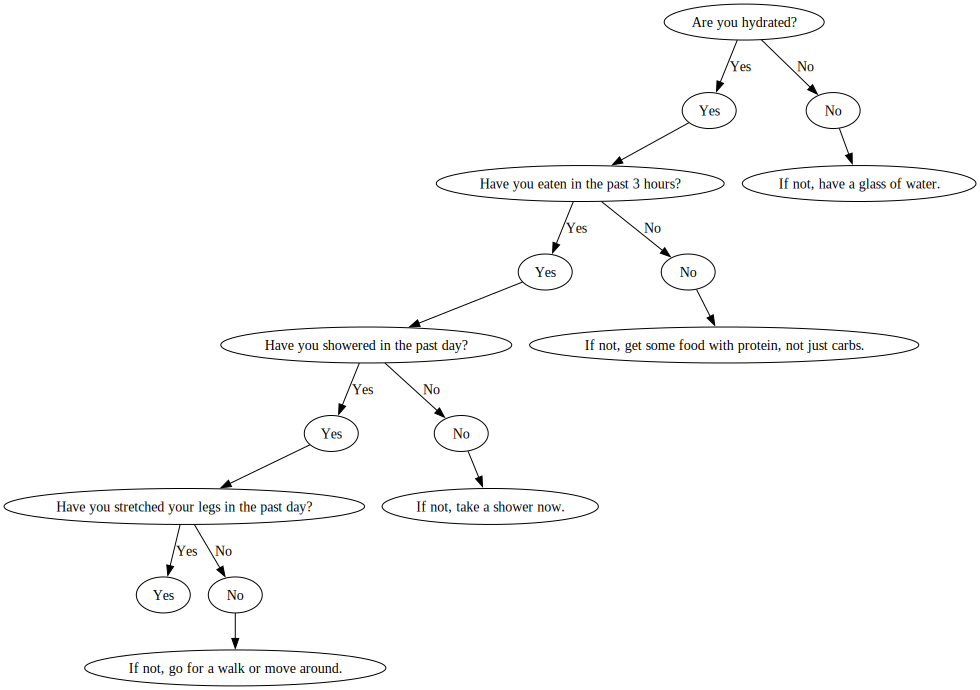

In [ ]:
graph = create_foul_mood_flowchart()
graph.render('images/foulmood_flowchart',format='svg',)
SVG('images/foulmood_flowchart.svg')

In [ ]:
from humble_chuck.models import BaseModel
from pydantic import ConfigDict

Now let's model some of these attributes. Graphviz has 3 primary objects: graphs, nodes, and edges. There are also subgraphs and cluster but let's get to that later. We'll start with the edges. 

But first, let's create a BaseModel that we can use to define common characteristics of our sub-models.

In [ ]:
class GraphVizModel(BaseModel):
    "BaseModel for GraphViz Pydantic models. Used to define common attributes for Graph, Node, and Edge."
    model_config = ConfigDict(repr_kwargs = {'exclude_unset':True})
    
    fontsize: Optional[str] = None
    

In [ ]:
class Edge(GraphVizModel):
    tail_name: str
    head_name: str
    label: Optional[str] = None
    # other edge attributes

Moving on to a NodeModel. 

In [ ]:
class Node(GraphVizModel):
    """Node Model"""
    name: str
    label: str
    pos: Optional[str] = None
    constraint: Optional[bool] = None
    # other attributes for graphviz nodes
    

In [ ]:
class GraphModel(GraphVizModel):
    type: Literal['graph','digraph']
    name: str
    format: Optional[str] = None
    
    nodes: List[Node]
    edges: Optional[List[Edge]] = []

    def make_graph(self):
        graph_kwargs = self.model_dump(exclude={'nodes','edges'}) 
        if self.type == 'graph':
            graph = Graph()
        else:
            graph = Digraph()
        nodes_edges = self.model_dump(include={'nodes','edges'})
        for node in nodes_edges['nodes']:
            graph.node(**node)
        for edge in nodes_edges['edges']:
            graph.edge(**edge)
        return graph

GraphModel(fontsize=None, type='graph', name='basic needs', format=None, nodes=[Node(fontsize=None, name='eaten', label='Have you eaten?', pos=None, constraint=None), Node(fontsize=None, name='eat', label='Eat you idiot!', pos=None, constraint=None), Node(fontsize=None, name='slept', label='Have you slept?', pos=None, constraint=None), Node(fontsize=None, name='sleep', label='Go to bed!', pos=None, constraint=None)], edges=[Edge(fontsize=None, tail_name='eaten', head_name='eat', label='No'), Edge(fontsize=None, tail_name='eaten', head_name='slept', label='Yes'), Edge(fontsize=None, tail_name='slept', head_name='sleep', label=None)])

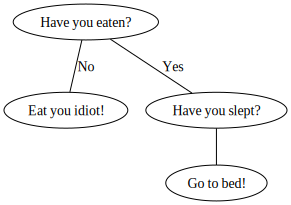

In [ ]:
graph = GraphModel(
    type='graph',
    name='basic needs',
    nodes = [
        Node(name='eaten',label="Have you eaten?",),
        Node(name='eat',label='Eat you idiot!'),
        Node(name='slept',label="Have you slept?"),
        Node(name='sleep',label='Go to bed!')
    ],
    edges = [
        Edge(head_name='eat',tail_name='eaten',label='No'),
        Edge(tail_name='eaten',head_name='slept',label='Yes'),
        Edge(tail_name='slept',head_name='sleep'),
        
        
    ]
)
display(graph)

graph.make_graph()

Not bad, but notice how different the definition and json representation of the graph are from the actual image. I would much prefer a hierarchal way of defining and modeling my basic needs flow chart. I would much rather have something like this:

```
Graph(
    Node(
        name='have you eaten',
        child_nodes={
            'no':Node('eat'),
            'yes':Node(
                name ='have you slept'
                child_nodes={'no':Node('sleep')}
                )
        }
    )
)
```

Something to consider: 

Should we have 'child-nodes' that are able to set their attribute relevant to the parent? I don't see a way of doing this with Graphviz natively. If so, Node would have to be a [self-refrencing model](https://docs.pydantic.dev/latest/concepts/forward_annotations/#self-referencing-or-recursive-models)

